# 1. Προετοιμασία δεδομένων

#### 1.0 Import τα απατούμενα packages της Python

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import re

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps

import torch

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils import resample
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from tqdm.notebook import tqdm

from collections import Counter

from neural_network_classifier import OscarClassificationNeuralNetwork, accuracy_fn

from plotting_functions import plot_roc_curves, plot_classification_reports_averages, plot_confusion_matrices
from classifiers import build_resampled_datasets, k_fold_fit_and_test, best_f1_score_for_each_sampling_method, k_fold_fit_and_test_knn, k_fold_fit_and_test_rf

# from google.colab import drive
# drive.mount('/content/drive')
import pickle

# 5. Μοντέλα προβλέψεων - τεχνικές αντιμετώπισης ανισόρροπων δεδομένων

https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/#h-3-smote

In [2]:
# df_un_cl.to_csv('./cleaned_dataframe_unknown.csv', index=False)
# df_cl.to_csv('./cleaned_dataframe_train.csv', index=False)

In [3]:
df_un_cl = pd.read_csv('./cleaned_dataframe_unknown.csv')
df_cl = pd.read_csv('./cleaned_dataframe_train.csv')
df_un_orig = pd.read_excel('movies_test_anon.xlsx')

In [4]:
model_results = {}

## TESTING PCA ON UNKNOWN DATASET

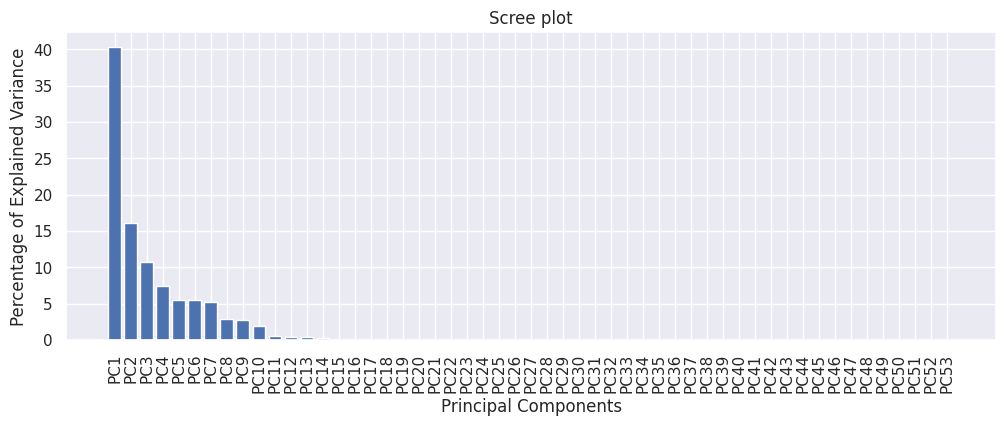

In [5]:
df_un_cl_corr = df_un_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail' , 'average_critics', 'average_audience'], axis=1)
x = df_un_cl_corr
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

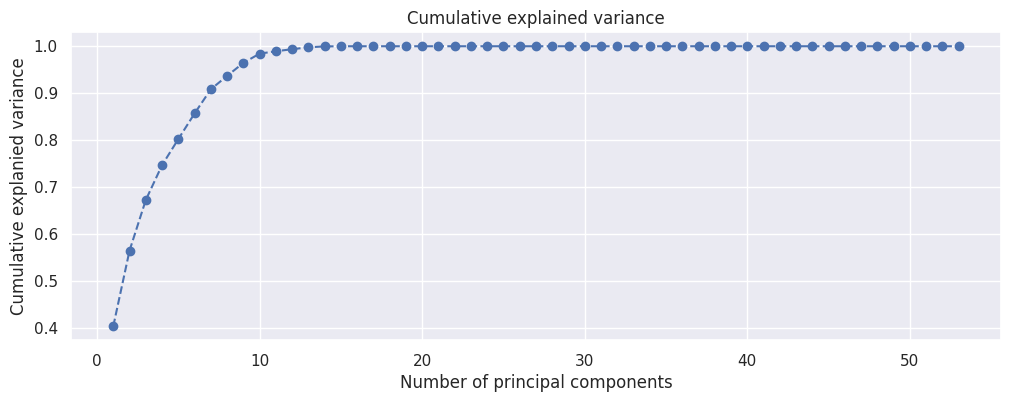

In [6]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

In [7]:
# Calculate PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
df_un_cl = pd.concat([df_un_cl, principal_components_df], axis=1)

## ADA Boost

In [8]:
# df = df_cl.drop(['film','year', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)',
#                     'oscar_detail'], axis=1)

df = df_cl[['PC1', 'PC2', 'oscar_winners']]

# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'oscar_winners']]

train_datasets, test_dataset = build_resampled_datasets(df)

In [9]:
#Ada boost
model = AdaBoostClassifier(n_estimators=100, random_state=0)
results = k_fold_fit_and_test(model, train_datasets, test_dataset)
model_results['ADA'] = results

Fold 1 1-F1 score: 0.3125 for default
Fold 2 1-F1 score: 0.5000 for default
Fold 3 1-F1 score: 0.6667 for default
Fold 4 1-F1 score: 0.4000 for default
Fold 5 1-F1 score: 0.5000 for default
Fold 1 1-F1 score: 0.4545 for upsampled
Fold 2 1-F1 score: 0.3478 for upsampled
Fold 3 1-F1 score: 0.4545 for upsampled
Fold 4 1-F1 score: 0.4000 for upsampled
Fold 5 1-F1 score: 0.3448 for upsampled
Fold 1 1-F1 score: 0.1961 for downsampled
Fold 2 1-F1 score: 0.3000 for downsampled
Fold 3 1-F1 score: 0.3429 for downsampled
Fold 4 1-F1 score: 0.1720 for downsampled
Fold 5 1-F1 score: 0.3636 for downsampled
Fold 1 1-F1 score: 0.3871 for SMOTE
Fold 2 1-F1 score: 0.4828 for SMOTE
Fold 3 1-F1 score: 0.4545 for SMOTE
Fold 4 1-F1 score: 0.6154 for SMOTE
Fold 5 1-F1 score: 0.5161 for SMOTE


## Gradient Boost

In [10]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'opening_weekend_($million)', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'budget_($million)', 'oscar_winners']]

train_datasets, test_dataset = build_resampled_datasets(df)

In [11]:
# Gradient boosting classifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
results = k_fold_fit_and_test(model, train_datasets, test_dataset)
model_results['GRB'] = results

Fold 1 1-F1 score: 0.3590 for default


Fold 2 1-F1 score: 0.0000 for default
Fold 3 1-F1 score: 0.6316 for default
Fold 4 1-F1 score: 0.0000 for default
Fold 5 1-F1 score: 0.2857 for default
Fold 1 1-F1 score: 0.4324 for upsampled
Fold 2 1-F1 score: 0.3636 for upsampled
Fold 3 1-F1 score: 0.5714 for upsampled
Fold 4 1-F1 score: 0.5263 for upsampled
Fold 5 1-F1 score: 0.3590 for upsampled
Fold 1 1-F1 score: 0.1818 for downsampled
Fold 2 1-F1 score: 0.3279 for downsampled
Fold 3 1-F1 score: 0.3667 for downsampled
Fold 4 1-F1 score: 0.2381 for downsampled
Fold 5 1-F1 score: 0.4828 for downsampled
Fold 1 1-F1 score: 0.3830 for SMOTE
Fold 2 1-F1 score: 0.4324 for SMOTE
Fold 3 1-F1 score: 0.5714 for SMOTE
Fold 4 1-F1 score: 0.4865 for SMOTE
Fold 5 1-F1 score: 0.4091 for SMOTE


## Decision Tree

In [12]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'opening_weekend_($million)', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'budget_($million)', 'oscar_winners']]

train_datasets, test_dataset = build_resampled_datasets(df)

In [13]:
# Decision tree classifier
model = DecisionTreeClassifier(criterion='gini', splitter='best')
results = k_fold_fit_and_test(model, train_datasets, test_dataset)
model_results['DT'] = results

Fold 1 1-F1 score: 0.4103 for default
Fold 2 1-F1 score: 0.4091 for default
Fold 3 1-F1 score: 0.6364 for default
Fold 4 1-F1 score: 0.6250 for default
Fold 5 1-F1 score: 0.7500 for default
Fold 1 1-F1 score: 0.5000 for upsampled
Fold 2 1-F1 score: 0.5116 for upsampled
Fold 3 1-F1 score: 0.4667 for upsampled
Fold 4 1-F1 score: 0.4651 for upsampled
Fold 5 1-F1 score: 0.5366 for upsampled
Fold 1 1-F1 score: 0.2750 for downsampled
Fold 2 1-F1 score: 0.4400 for downsampled
Fold 3 1-F1 score: 0.1654 for downsampled
Fold 4 1-F1 score: 0.3333 for downsampled
Fold 5 1-F1 score: 0.4545 for downsampled
Fold 1 1-F1 score: 0.4167 for SMOTE
Fold 2 1-F1 score: 0.4490 for SMOTE
Fold 3 1-F1 score: 0.3860 for SMOTE
Fold 4 1-F1 score: 0.4000 for SMOTE
Fold 5 1-F1 score: 0.4889 for SMOTE


## Random Forest

In [14]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'opening_weekend_($million)', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'budget_($million)', 'oscar_winners']]

train_datasets, test_dataset = build_resampled_datasets(df)

In [15]:
# Random forest
# model = RandomForestClassifier()
results = k_fold_fit_and_test_rf(train_datasets, test_dataset)
model_results['RF'] = results

Fold 1 1-F1 score: 0.3590 for default
Fold 2 1-F1 score: 0.4571 for default
Fold 3 1-F1 score: 0.5000 for default
Fold 4 1-F1 score: 0.1538 for default
Fold 5 1-F1 score: 0.6957 for default
Fold 1 1-F1 score: 0.3704 for upsampled
Fold 2 1-F1 score: 0.3333 for upsampled
Fold 3 1-F1 score: 0.4167 for upsampled
Fold 4 1-F1 score: 0.3478 for upsampled
Fold 5 1-F1 score: 0.4545 for upsampled
Fold 1 1-F1 score: 0.2933 for downsampled
Fold 2 1-F1 score: 0.2418 for downsampled
Fold 3 1-F1 score: 0.2222 for downsampled
Fold 4 1-F1 score: 0.2418 for downsampled
Fold 5 1-F1 score: 0.3077 for downsampled
Fold 1 1-F1 score: 0.4348 for SMOTE
Fold 2 1-F1 score: 0.5405 for SMOTE
Fold 3 1-F1 score: 0.6667 for SMOTE
Fold 4 1-F1 score: 0.4091 for SMOTE
Fold 5 1-F1 score: 0.4762 for SMOTE


In [16]:
model_results['RF']['default'][0].keys()

dict_keys(['fold', 'report', 'preds', 'true', 'best_k', 'X_train', 'y_train'])

## K-Nearest Neighbors

In [17]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'oscar_winners']]

# df = df_cl[['PC1', 'PC2', 'oscar_winners']]

# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'oscar_winners']]

train_datasets, test_dataset = build_resampled_datasets(df)

In [18]:
#KNN
results = k_fold_fit_and_test_knn(train_datasets, test_dataset)
model_results['KNN'] = results

Fold 1 1-F1 score: 0.5217 for default
Fold 2 1-F1 score: 0.4706 for default
Fold 3 1-F1 score: 0.0000 for default
Fold 4 1-F1 score: 0.2857 for default
Fold 5 1-F1 score: 0.2857 for default
Fold 1 1-F1 score: 0.4667 for upsampled
Fold 2 1-F1 score: 0.4118 for upsampled
Fold 3 1-F1 score: 0.4444 for upsampled
Fold 4 1-F1 score: 0.4516 for upsampled
Fold 5 1-F1 score: 0.4615 for upsampled
Fold 1 1-F1 score: 0.3636 for downsampled
Fold 2 1-F1 score: 0.3226 for downsampled
Fold 3 1-F1 score: 0.3548 for downsampled
Fold 4 1-F1 score: 0.3590 for downsampled
Fold 5 1-F1 score: 0.2500 for downsampled
Fold 1 1-F1 score: 0.4865 for SMOTE
Fold 2 1-F1 score: 0.5366 for SMOTE
Fold 3 1-F1 score: 0.4400 for SMOTE
Fold 4 1-F1 score: 0.4490 for SMOTE
Fold 5 1-F1 score: 0.5000 for SMOTE


## Plot results

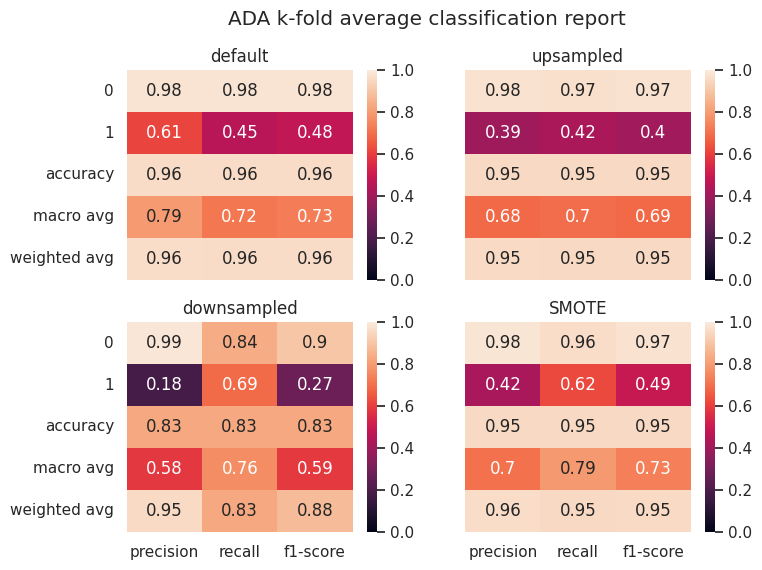

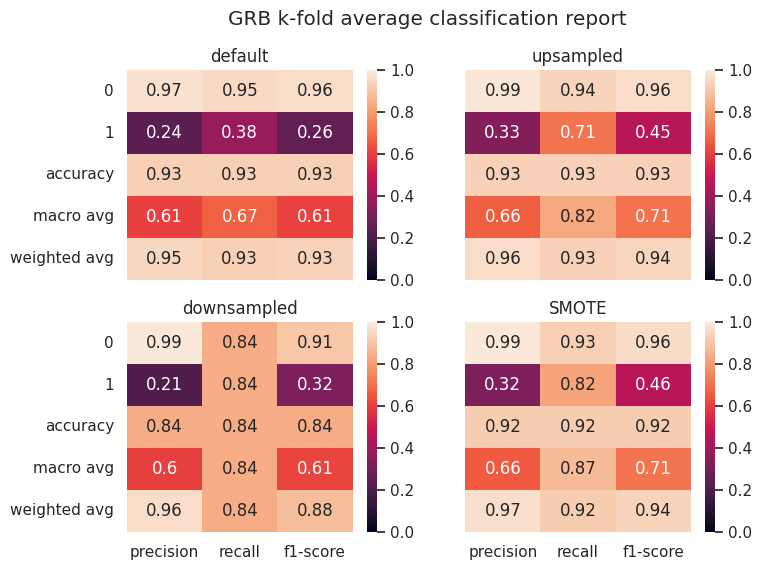

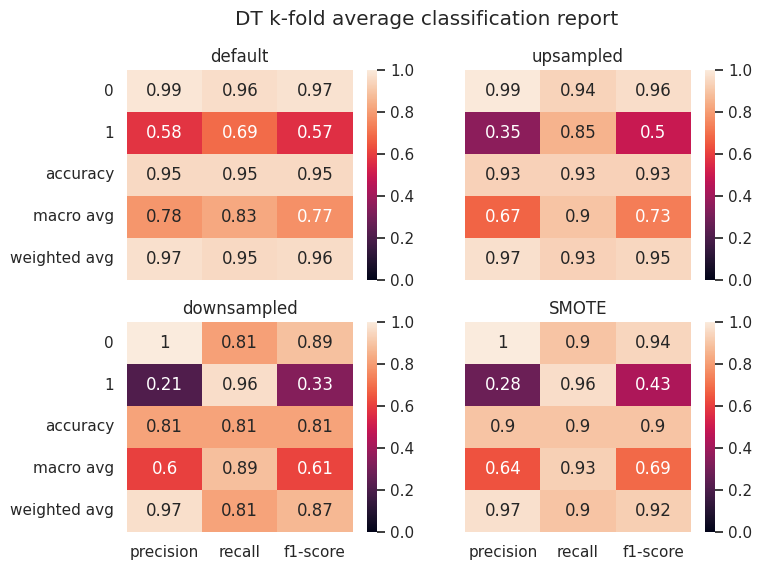

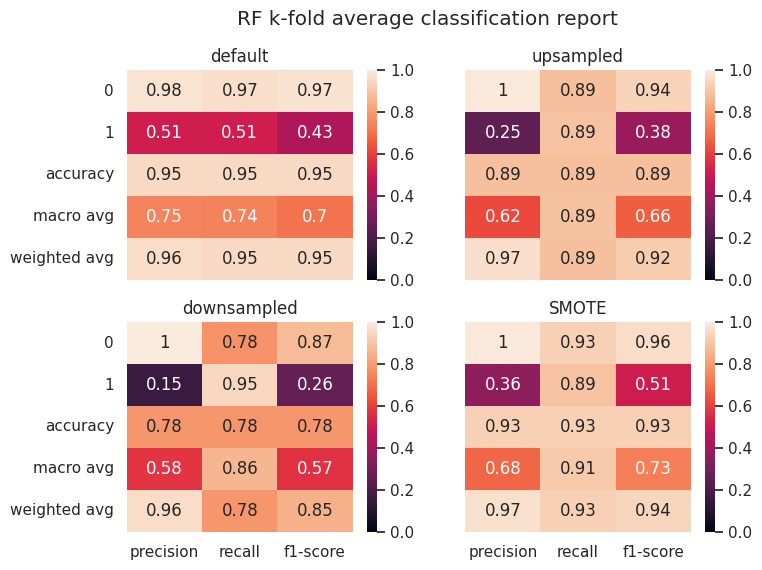

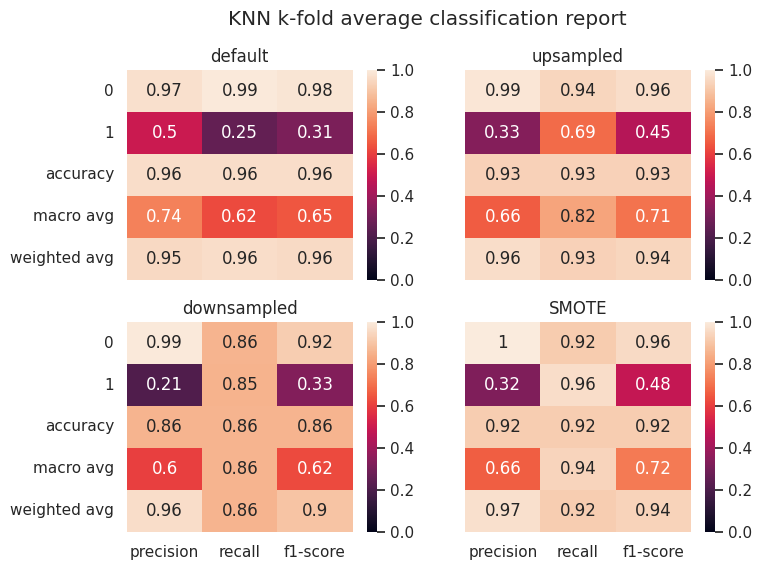

In [19]:
plot_classification_reports_averages(model_results, 'ADA')
plot_classification_reports_averages(model_results, 'GRB')
plot_classification_reports_averages(model_results, 'DT')
plot_classification_reports_averages(model_results, 'RF')
plot_classification_reports_averages(model_results, 'KNN')

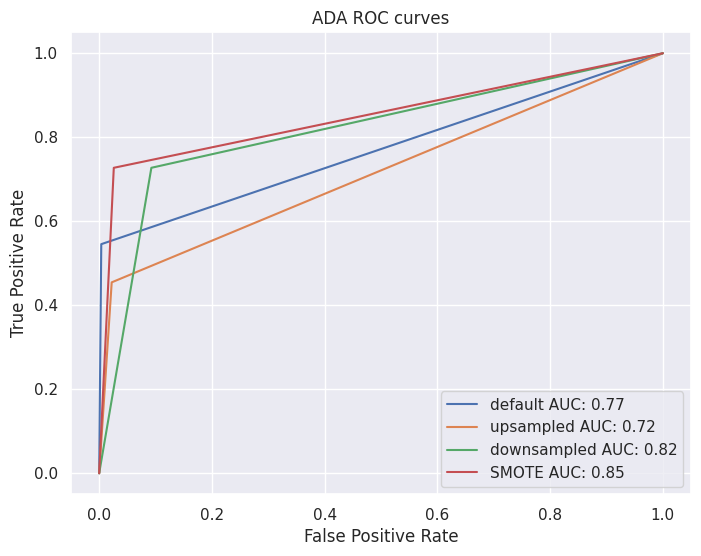

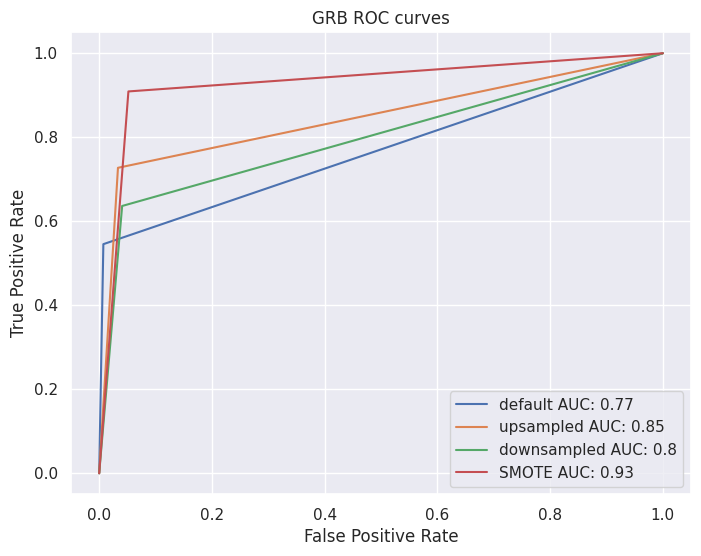

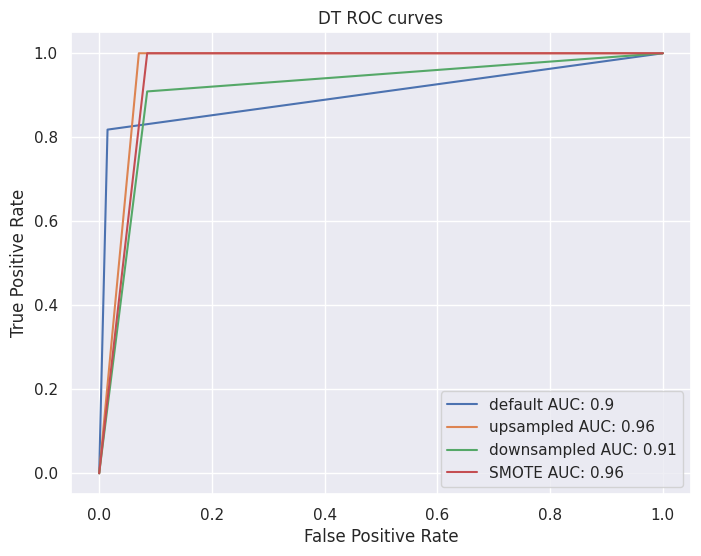

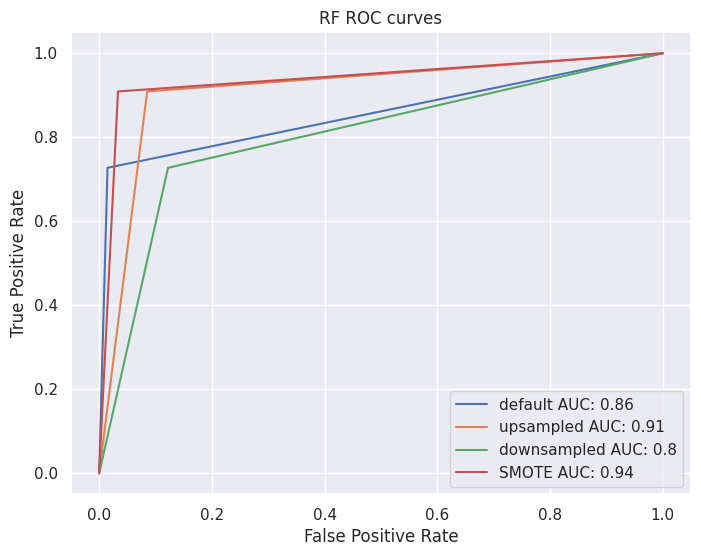

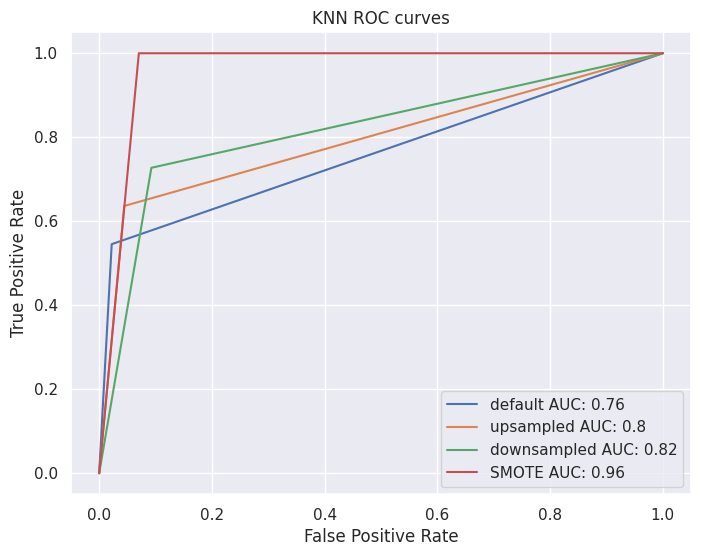

In [20]:
best_f1_ada = best_f1_score_for_each_sampling_method(model_results, 'ADA')
plot_roc_curves(best_f1_ada, 'ADA')
best_f1_grb = best_f1_score_for_each_sampling_method(model_results, 'GRB')
plot_roc_curves(best_f1_grb, 'GRB')
best_f1_dt = best_f1_score_for_each_sampling_method(model_results, 'DT')
plot_roc_curves(best_f1_dt, 'DT')
best_f1_rf = best_f1_score_for_each_sampling_method(model_results, 'RF')
plot_roc_curves(best_f1_rf, 'RF')
best_f1_knn = best_f1_score_for_each_sampling_method(model_results, 'KNN')
plot_roc_curves(best_f1_knn, 'KNN')

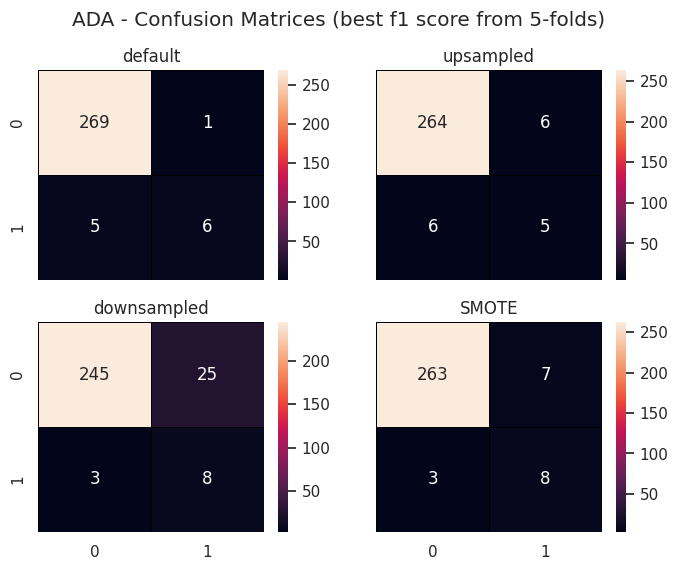

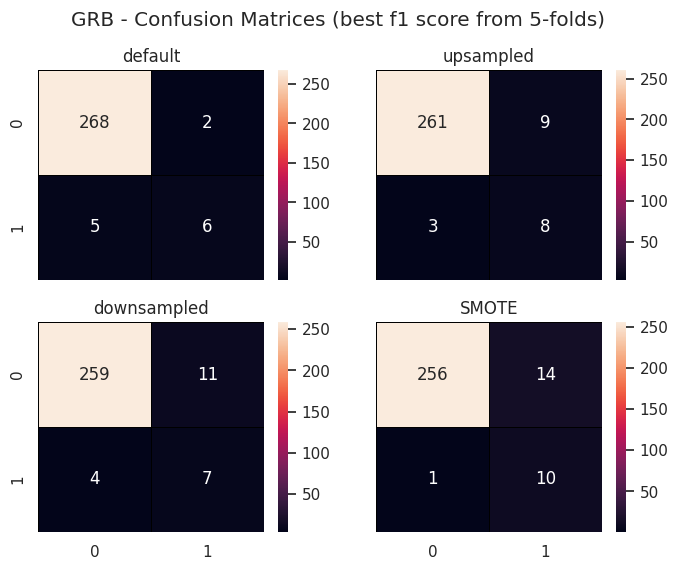

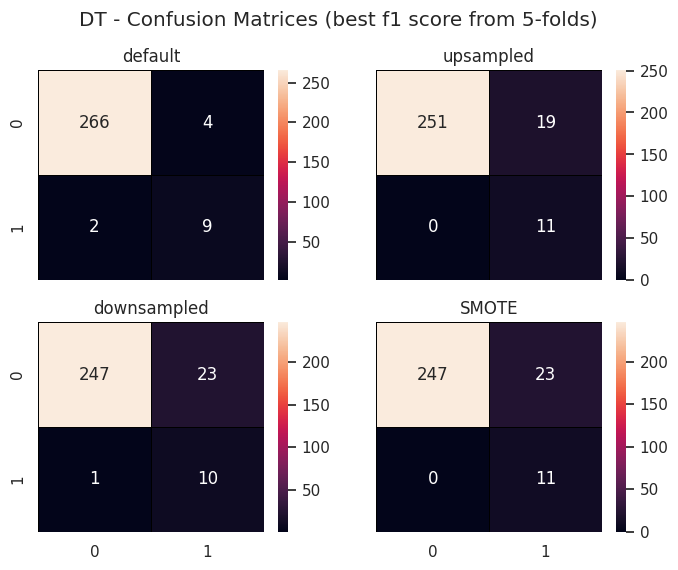

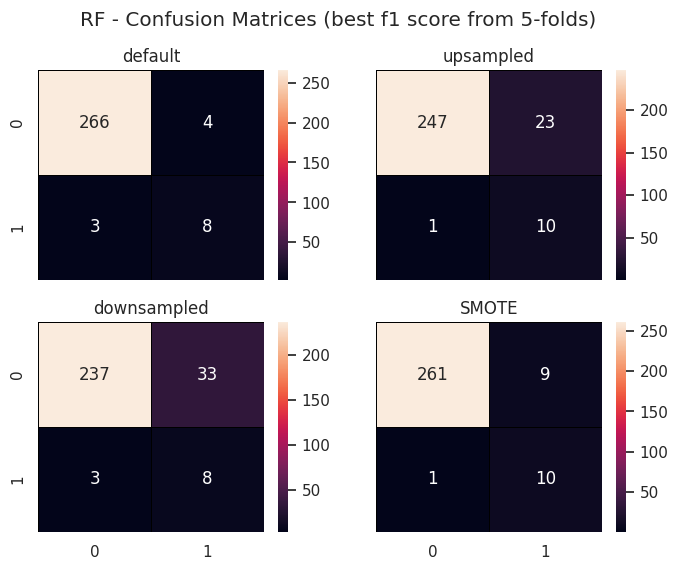

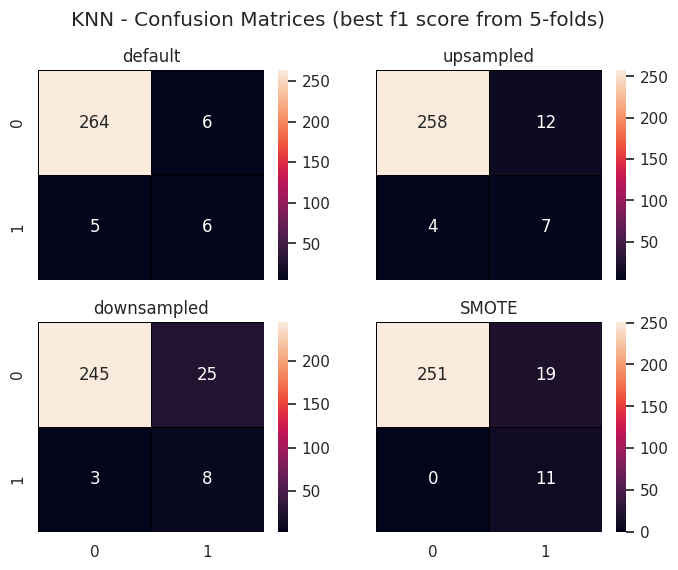

In [21]:
plot_confusion_matrices(best_f1_ada, 'ADA')
plot_confusion_matrices(best_f1_grb, 'GRB')
plot_confusion_matrices(best_f1_dt, 'DT')
plot_confusion_matrices(best_f1_rf, 'RF')
plot_confusion_matrices(best_f1_knn, 'KNN')

# 6. Predictions on unknown dataset

#### Select unknown dataset features

In [22]:
df_un_cl_predictions = df_cl[['PC1', 'PC2']]
X = df_un_cl_predictions.values

### 6.1 ADA Boost

In [23]:
best_overall_ada = max(best_f1_ada.values(), key=lambda a:a['report']['1']['f1-score'])

model = AdaBoostClassifier(n_estimators=100, random_state=0)

model.fit(best_overall_ada['X_train'], best_overall_ada['y_train'])
un_preds = model.predict(X)

df_un_orig[f'ADA'] = pd.DataFrame(un_preds)
ada_n_predicted_oscars = len(df_un_orig[df_un_orig['ADA'] == 1])
ada_n_predicted_oscars

10

### 6.2 Gradient Boost

In [24]:
best_overall_grb = max(best_f1_grb.values(), key=lambda a:a['report']['1']['f1-score'])

model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

model.fit(best_overall_ada['X_train'], best_overall_ada['y_train'])
un_preds = model.predict(X)

df_un_orig[f'GRB'] = pd.DataFrame(un_preds)
grb_n_predicted_oscars= len(df_un_orig[df_un_orig['GRB'] == 1])
grb_n_predicted_oscars

10

### 6.3 Decision Tree

In [25]:
best_overall_dt = max(best_f1_dt.values(), key=lambda a:a['report']['1']['f1-score'])

model = DecisionTreeClassifier(criterion='gini', splitter='best')

model.fit(best_overall_dt['X_train'], best_overall_dt['y_train'])
un_preds = model.predict(X)

df_un_orig[f'DT'] = pd.DataFrame(un_preds)
dt_n_predicted_oscars = len(df_un_orig[df_un_orig['DT'] == 1])
dt_n_predicted_oscars

19

### 6.4 Random Forest

In [26]:
best_overall_rf = max(best_f1_rf.values(), key=lambda a:a['report']['1']['f1-score'])

model = RandomForestClassifier(max_depth=best_overall_rf['best_k'])

model.fit(best_overall_rf['X_train'], best_overall_rf['y_train'])
un_preds = model.predict(X)

df_un_orig[f'RF'] = pd.DataFrame(un_preds)
rf_n_predicted_oscars = len(df_un_orig[df_un_orig['RF'] == 1])
rf_n_predicted_oscars

11

### 6.5 K-Nearest Neighbors

In [27]:
best_overall_knn = max(best_f1_knn.values(), key=lambda a:a['report']['1']['f1-score'])

model = KNeighborsClassifier(n_neighbors=best_overall_knn['best_k'])
model.fit(best_overall_knn['X_train'], best_overall_knn['y_train'])

un_preds = model.predict(X)
preds_df = pd.DataFrame(un_preds)
df_un_orig[f'KNN'] = preds_df

knn_n_predicted_oscars = len(df_un_orig[df_un_orig['KNN'] == 1])
knn_n_predicted_oscars

42

## Show all model predictons

In [28]:
#['ADA', 'GRB', 'DT','RF', 'KNN']
n_oscar_preds = pd.DataFrame([[ada_n_predicted_oscars, grb_n_predicted_oscars, dt_n_predicted_oscars, rf_n_predicted_oscars, knn_n_predicted_oscars]], columns=['ADA', 'GRB', 'DT','RF', 'KNN'])

Number of predictions per model

In [29]:
n_oscar_preds

,ADA,GRB,DT,RF,KNN
0,10,10,19,11,42


Detailed predictions view

In [30]:
# df_un_orig[(df_un_orig['ADA'] == 1) | (df_un_orig['GRB'] == 1) | (df_un_orig['DT'] == 1) | (df_un_orig['RF'] == 1) | (df_un_orig['KNN'] == 1)][['ADA', 'GRB', 'DT','RF', 'KNN']]

Select final oscar prediction criteria

In [40]:
DECISION_THRESHOLD = 3

predictions = df_un_orig[['ID', 'ADA', 'GRB', 'DT','RF', 'KNN']]
predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)

/tmp/ipykernel_15522/3176874214.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)


Overall oscar prediction number

In [41]:
len(predictions[predictions['OSCAR'] == 1])

14

In [42]:
print(f"Unkn dataset predicted oscar ratio: {len(predictions[predictions['OSCAR'] == 1]) / len(predictions) * 100:.2f}% | Testing dataset oscar prediction ratio: {len(df_cl[df_cl['oscar_winners'] == 1]) / len(df_cl) * 100:.2f}%")

Unkn dataset predicted oscar ratio: 2.48% | Testing dataset oscar prediction ratio: 3.99%


In [43]:
# Save file
# predictions.to_csv('./predictions.csv', index=False)